In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy


In [88]:
engine = sqlalchemy.create_engine(r"sqlite:///D:\alphavantage\daily_close_adj_av.db")

In [89]:
b_df = pd.DataFrame( )
# Select stock pair (example: Goldman Sachs and Caterpillar)
stock1 = "GS"
stock2 = "CAT"
stocks = [ stock1 , stock2 ]
for stock in stocks :
    
    query = f"SELECT * FROM {stock}"
    df = pd.read_sql_query( query , engine  )[['index','5. adjusted close']]
    df['index'] = pd.to_datetime( df['index'] )
    df  =  df.set_index('index')
    df = df[~df.index.duplicated(keep='first')]
    b_df[f'{stock}'] = df.astype('float')

b_df = b_df.dropna()

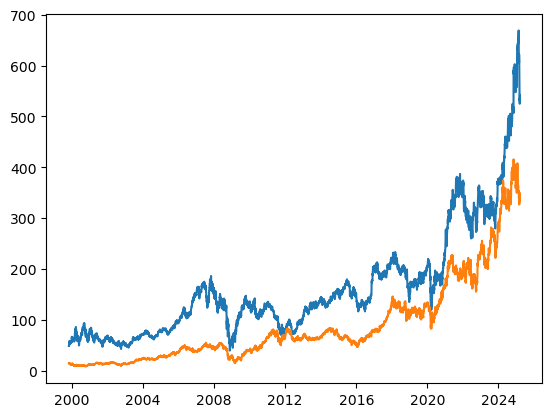

In [90]:
plt.plot(b_df)

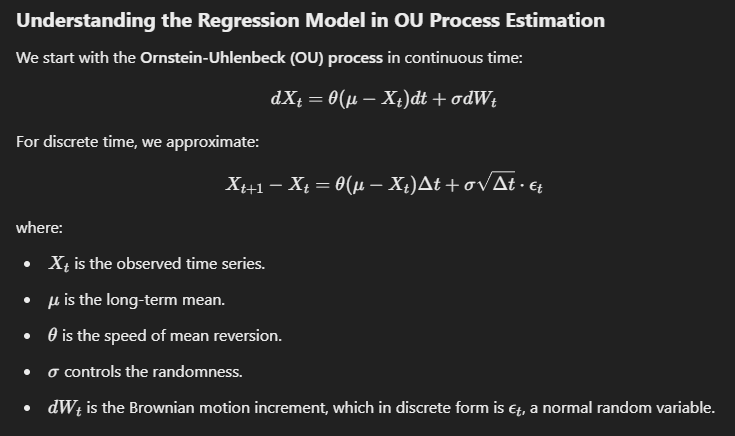

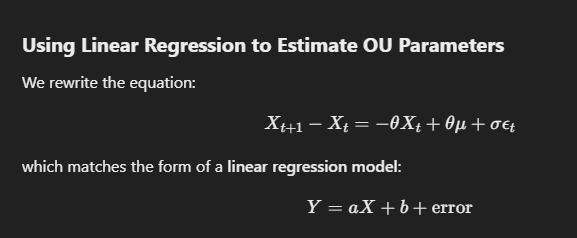

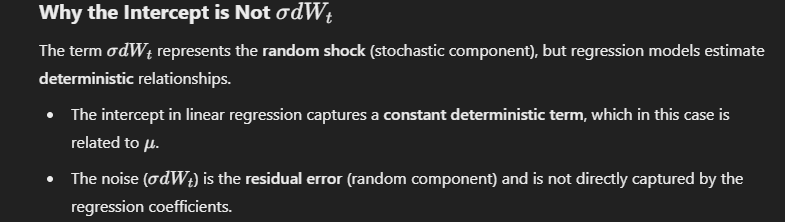

In [91]:
spread = b_df['GS'] - b_df['CAT']

C:\Users\zig53\AppData\Local\Temp\ipykernel_15392\2105325055.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]  # Beta coefficient (hedge ratio)
C:\Users\zig53\AppData\Local\Temp\ipykernel_15392\2105325055.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if spread[i] >= long_term_mean + entry_signal:
C:\Users\zig53\AppData\Local\Temp\ipykernel_15392\2105325055.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `

Cointegration Test p-value: 0.0003, Hedge Ratio: 0.7461
GS and CAT are cointegrated. Proceeding with backtest.


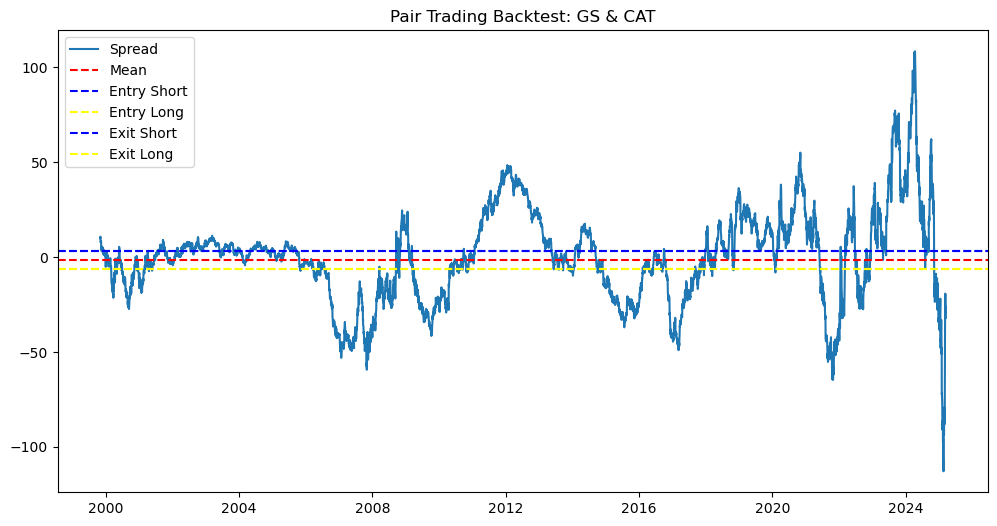

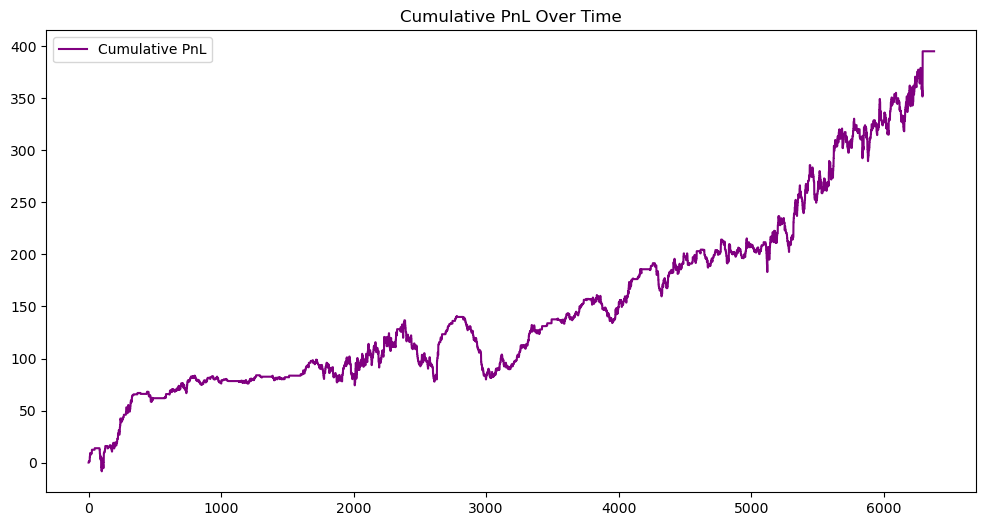

In [109]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Function to check cointegration
def cointegration_test(series1, series2):

    X = sm.add_constant(series1)
    model = sm.OLS(series2, X).fit()
    residuals = model.resid
    p_value = adfuller(residuals)[1]  # ADF test on residuals
    hedge_ratio = model.params[1]  # Beta coefficient (hedge ratio)
    
    return p_value, hedge_ratio, residuals

# Function to estimate Ornstein-Uhlenbeck parameters
def estimate_ou_params(spread):
    
    spread_diff = np.diff(spread)
    spread_lag = spread[:-1]
    
    # Estimate mean-reversion speed (theta) using linear regression
    theta, intercept = np.polyfit(spread_lag, spread_diff, 1)

    long_term_mean = -intercept / theta
    variance = np.var(spread_diff)
    sigma = np.sqrt(variance)
    
    return theta, long_term_mean, sigma

# Function to backtest pair trading strategy with dollar-based sizing
import numpy as np

def pair_trading_backtest(spread, price_a, price_b, theta, long_term_mean, sigma, hedge_ratio, capital_per_trade=100, entry_threshold=0.5, exit_threshold=0.5):

    positions = []
    entry_signal = entry_threshold * sigma
    exit_signal = exit_threshold * sigma
    position = 0  # 1 for long, -1 for short, 0 for no position
    pnl = 0
    trade_log = []
    cumulative_pnl = []
    log_ret = [ ]

    price_a = price_a.to_numpy()
    price_b = price_b.to_numpy()

    for i in range(len(spread)):
        
        if position == 0:
            capital_allocated = capital_per_trade / (1 + hedge_ratio)
            
            # Corrected share calculation using actual asset prices
            num_shares1 = 1#capital_allocated / price_a[i]  # Shares for Asset1
            num_shares2 = hedge_ratio#(capital_allocated * hedge_ratio) / price_b[i]  # Scaled by hedge ratio

            if spread[i] >= long_term_mean + entry_signal:
                position = -1  # Short spread (sell asset1, buy asset2)
                trade_log.append(("Short", i, spread[i], price_a[i], price_b[i], num_shares1, num_shares2))
            
            elif spread[i] <= long_term_mean - entry_signal:
                position = 1  # Long spread (buy asset1, sell asset2)
                trade_log.append(("Long", i, spread[i], price_a[i], price_b[i], num_shares1, num_shares2))

        elif position == -1 and spread[i] >= long_term_mean - exit_signal:
            entry_spread, entry_price_a, entry_price_b, num_shares1, num_shares2 = trade_log[-1][2:]

            # Corrected PnL Calculation
            pnl_trade = (price_a[i] - entry_price_a) * num_shares1 - (price_b[i] - entry_price_b) * num_shares2
            pnl += pnl_trade  # Update total PnL

            trade_log.append(("Close Long", i, spread[i], price_a[i], price_b[i], pnl_trade, pnl))
            position = 0  # Close position

        elif position ==  1 and spread[i] <= long_term_mean + exit_signal:
            entry_spread, entry_price_a, entry_price_b, num_shares1, num_shares2 = trade_log[-1][2:]

            # Corrected PnL Calculation
            pnl_trade = (entry_price_a - price_a[i]) * num_shares1 - (entry_price_b - price_b[i]) * num_shares2
            pnl += pnl_trade  # Update total PnL

            trade_log.append(("Close Short", i, spread[i], price_a[i], price_b[i], pnl_trade, pnl))
            position = 0  # Close position

        positions.append(position)
        cumulative_pnl.append(pnl)

    return positions, trade_log, cumulative_pnl , log_ret


# Perform cointegration test
p_value, hedge_ratio, spread = cointegration_test( b_df[f'{stock1}'] , b_df[f'{stock2}'] )
print(f"Cointegration Test p-value: {p_value:.4f}, Hedge Ratio: {hedge_ratio:.4f}")

if p_value < 0.05:  # Only proceed if stocks are cointegrated
    print(f"{stock1} and {stock2} are cointegrated. Proceeding with backtest.")

    # Estimate Ornstein-Uhlenbeck parameters
    theta, long_term_mean, sigma = estimate_ou_params(spread)

    ent_thres = 2
    ext_thres = 2
    # Run backtest
    positions, trade_log, cumulative_pnl , log_ret = pair_trading_backtest(spread, b_df[f'{stock1}'] , b_df[f'{stock2}'] , theta, long_term_mean, sigma, hedge_ratio, entry_threshold=ent_thres, exit_threshold=ext_thres)

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(spread, label="Spread")
    plt.axhline(long_term_mean, color='red', linestyle='--', label="Mean")
    plt.axhline(long_term_mean + ent_thres * sigma, color='blue', linestyle='--', label="Entry Short")
    plt.axhline(long_term_mean - ext_thres * sigma, color='yellow', linestyle='--', label="Entry Long")
    plt.axhline(long_term_mean + ent_thres * sigma, color='blue', linestyle='--', label="Exit Short")
    plt.axhline(long_term_mean - ext_thres * sigma, color='yellow', linestyle='--', label="Exit Long")
    plt.legend()
    plt.title(f"Pair Trading Backtest: {stock1} & {stock2}")
    plt.show()

    # Plot cumulative PnL
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_pnl, label="Cumulative PnL", color='purple')
    plt.legend()
    plt.title("Cumulative PnL Over Time")
    plt.show()
else:
    print(f"{stock1} and {stock2} are not cointegrated. Try another pair.")


In [ ]:
#parameters tuning
pnl = []
for i in np.arange( 0.5 , 2.25 , 0.25 ):
    for j in np.arange( 0.5 , 2.25 , 0.25 ):

        p = pair_trading_backtest(spread, b_df[f'{stock1}'] , b_df[f'{stock2}'] , theta, long_term_mean, sigma, hedge_ratio ,  entry_threshold=i, exit_threshold=j )[2][-1]
        pnl.append([p,i,j])

C:\Users\zig53\AppData\Local\Temp\ipykernel_15392\229282979.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if spread[i] >= long_term_mean + entry_signal:
C:\Users\zig53\AppData\Local\Temp\ipykernel_15392\229282979.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trade_log.append(("Short", i, spread[i], price_a[i], price_b[i], num_shares1, num_shares2))
C:\Users\zig53\AppData\Local\Temp\ipykernel_15392\229282979.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a